## Text Analytics --- Salary Classification

In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

Select 2500 jobs for faster processing

In [2]:
df = pd.read_csv('Train_rev1.csv',nrows=30000)

In [3]:
np.random.seed(0)
df = df.iloc[np.random.choice(len(df),size=2500,replace=False)].reset_index()

Learn about our data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               2500 non-null   int64 
 1   Id                  2500 non-null   int64 
 2   Title               2500 non-null   object
 3   FullDescription     2500 non-null   object
 4   LocationRaw         2500 non-null   object
 5   LocationNormalized  2500 non-null   object
 6   ContractType        982 non-null    object
 7   ContractTime        1364 non-null   object
 8   Company             1731 non-null   object
 9   Category            2500 non-null   object
 10  SalaryRaw           2500 non-null   object
 11  SalaryNormalized    2500 non-null   int64 
 12  SourceName          2500 non-null   object
dtypes: int64(3), object(10)
memory usage: 254.0+ KB


In [5]:
df.head(3)

,index,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,8225,65171667,Senior Graphics Software Engineer,"Senior Graphics Engineer needed Open GL, C , ...",Middlesex,UK,NaN,permanent,NaN,IT Jobs,45000 - 55000 per annum,50000,theitjobboard.co.uk
1,10794,66434680,Sales Director Electrical/Connectors Rail,Excellent new opportunity has arisen due to an...,Saffron Walden,Saffron Walden,NaN,permanent,NaN,IT Jobs,"65000 - 75000 per annum + Car, bonus, pension ...",70000,theitjobboard.co.uk
2,9163,65765218,Junior Project Manager,As a Junior Project Manager you will be respon...,Leeds,Leeds,NaN,NaN,MBN Recruitment,IT Jobs,"25,000 + Benefits",25000,MyUkJobs


In [6]:
df.ContractType.value_counts()

full_time    826
part_time    156
Name: ContractType, dtype: int64

In [7]:
df.dropna(subset = ['FullDescription'],axis=0)
df.drop(labels=['index','Id','LocationRaw','SalaryRaw','SourceName'],axis=1,inplace=True)

In [8]:
df.ContractTime.value_counts()

permanent    1127
contract      237
Name: ContractTime, dtype: int64

In [9]:
df.SalaryNormalized.describe()

count      2500.000000
mean      32543.511600
std       18328.214161
min        5006.000000
25%       20000.000000
50%       28000.000000
75%       40000.000000
max      199680.000000
Name: SalaryNormalized, dtype: float64

In [10]:
df['SalaryNormalized'] = pd.qcut(df['SalaryNormalized'],q=[0,0.75,1],labels=['Low','High'])

In [11]:
df.head(3)

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,Senior Graphics Software Engineer,"Senior Graphics Engineer needed Open GL, C , ...",UK,NaN,permanent,NaN,IT Jobs,High
1,Sales Director Electrical/Connectors Rail,Excellent new opportunity has arisen due to an...,Saffron Walden,NaN,permanent,NaN,IT Jobs,High
2,Junior Project Manager,As a Junior Project Manager you will be respon...,Leeds,NaN,NaN,MBN Recruitment,IT Jobs,Low


In [12]:
df.rename(columns={'LocationNormalized':'Location','SalaryNormalized':'Salary'},inplace=True)

visualize the common words in the description and remove some not informative words

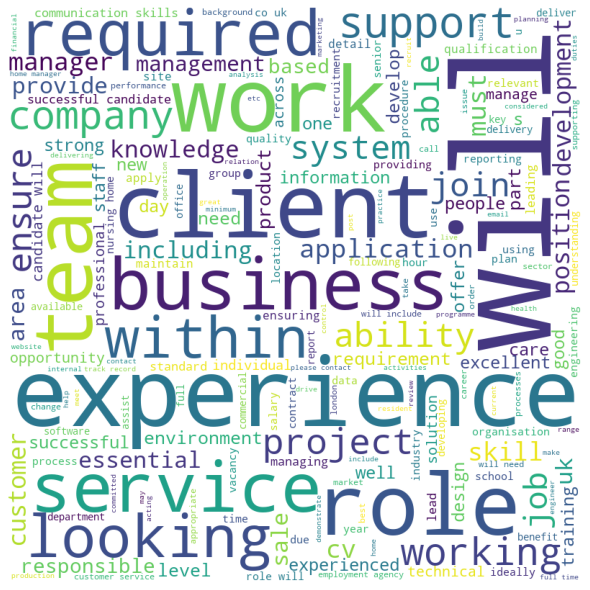

In [57]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comment_words = ''
stopwords1 = set(STOPWORDS)
# stopwords1.update(['will','work','role','job','require','required','within','ensure','level','include',
#                    'working','need','must','able','ability','candidate','position','application','looking',
#                   'apply','opportunity','applicant','join','industry','career','provide','providing','cv',
#                          'using','day','including','skill','environment','company'])
 
# iterate through the csv file
for val in df.FullDescription:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',prefer_horizontal=0.5,
                stopwords = stopwords1,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [14]:
train,test = train_test_split(df,test_size=0.2,random_state=0)

## 1. Build a classification model with text (full job description) as the predictor. 

In [15]:
X_train,y_train = train['FullDescription'], train['Salary']
X_test,y_test = test['FullDescription'], test['Salary']

In [16]:
word_tokenizer=RegexpTokenizer(r'[a-z]+')
# word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))
stop_words_custom = set(['will','work','role','job','require','required','within','ensure','level','include',
                   'working','need','must','able','ability','candidate','position','application','looking',
                  'apply','opportunity','applicant','join','industry','career','provide','providing','cv',
                         'using','day','including','skill','environment','company'])
# We inlucde both original word and its variation such as include and including,
# in case the word net lemmatizer cannot do this 
stop_words = stopwords_nltk | stop_words_custom

def remove_stopwords(text):
    output= [i for i in text if i not in stop_words]
    return output

def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    
    tokens = word_tokenizer.tokenize(lowercase)
    
    tokens_no_stopwords = remove_stopwords(tokens)

    text = [wordnet_lemmatizer.lemmatize(word) for word in tokens_no_stopwords]
    
    return text

### Try Sklearn for classification

In [17]:
vec_words = CountVectorizer(tokenizer=tokenize_text,decode_error='ignore')
#vec_words= TfidfVectorizer(tokenizer=tokenize_text,decode_error='ignore') # This method works way worse for our data
X_train_vect = vec_words.fit_transform(X_train)

In [18]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X=X_train_vect,y=y_train)

MultinomialNB()

In [19]:
X_test_vect = vec_words.transform(X_test)
y_pred = model.predict(X_test_vect)

In [20]:
confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)

0.824

### Use NLTK for classification
### NLTK allows us to see imformative features after fitting to the the models

In [21]:
features = [tokenize_text(X_train_i) for X_train_i in X_train]

In [22]:
features_flatten =[j for sub in features for j in sub]

In [23]:
all_words = nltk.FreqDist(features_flatten)
word_features = list(all_words)

In [24]:
documents = [(features[i],y_train.iloc[i]) for i in range(len(y_train))]

In [25]:
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [26]:
featuresets = [(document_features(d), c) for (d,c) in documents]
train_set = featuresets
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [27]:
featuresets[:1]

[({'contains(experience)': True,
   'contains(team)': True,
   'contains(client)': False,
   'contains(business)': True,
   'contains(service)': True,
   'contains(skill)': False,
   'contains(manager)': True,
   'contains(care)': False,
   'contains(please)': True,
   'contains(management)': True,
   'contains(support)': False,
   'contains(development)': False,
   'contains(sale)': True,
   'contains(uk)': True,
   'contains(project)': False,
   'contains(customer)': True,
   'contains(excellent)': True,
   'contains(home)': False,
   'contains(knowledge)': False,
   'contains(system)': True,
   'contains(new)': False,
   'contains(successful)': False,
   'contains(recruitment)': False,
   'contains(salary)': True,
   'contains(based)': False,
   'contains(good)': False,
   'contains(design)': False,
   'contains(training)': False,
   'contains(high)': True,
   'contains(year)': True,
   'contains(time)': False,
   'contains(strong)': False,
   'contains(requirement)': True,
   'cont

In [28]:
classifier.show_most_informative_features(20)

Most Informative Features
        contains(backed) = True             High : Low    =     23.1 : 1.0
            contains(vp) = True             High : Low    =     18.7 : 1.0
          contains(apps) = True             High : Low    =     16.5 : 1.0
         contains(night) = True              Low : High   =     14.9 : 1.0
     contains(alignment) = True             High : Low    =     14.3 : 1.0
       contains(broader) = True             High : Low    =     14.3 : 1.0
    contains(derivative) = True             High : Low    =     14.3 : 1.0
            contains(fx) = True             High : Low    =     14.3 : 1.0
          contains(gaap) = True             High : Low    =     14.3 : 1.0
        contains(huxley) = True             High : Low    =     14.3 : 1.0
             contains(o) = True             High : Low    =     14.3 : 1.0
    contains(partnering) = True             High : Low    =     13.8 : 1.0
    contains(governance) = True             High : Low    =     12.5 : 1.0

In [29]:
features_test = [tokenize_text(X_test_i) for X_test_i in X_test]
documents_test = [(features_test[i]) for i in range(len(y_test))]
featuresets = [(document_features(d)) for d in documents_test]

In [30]:
y_pred = [classifier.classify(featuresets[i]) for i in range(len(featuresets))]

In [31]:
accuracy_score(y_test,y_pred)

0.818

In [32]:
# [classifier.classify(featuresets[i]) for i in len(featuresets)]
confusion_matrix(y_test,y_pred)

array([[ 70,  59],
       [ 32, 339]])

In [33]:
# misclassified samples
df.iloc[(y_test!=y_pred)[(y_test!=y_pred)==True].index].head(5)

,Title,FullDescription,Location,ContractType,ContractTime,Company,Category,Salary
728,Interim Team Manager Disabled Children,Interim Team Manager Disabled Childrens Team ...,Wales,full_time,NaN,NaN,Healthcare & Nursing Jobs,High
1073,Consultant Social Worker Children s,Consultant Social Worker Worcestershire Dece...,Worcestershire,NaN,NaN,NaN,Healthcare & Nursing Jobs,High
330,Offshore Specialist Tax Senior,An opportunity to join this leading Top 10 fir...,London,NaN,permanent,NaN,Accounting & Finance Jobs,High
820,"SALES SPECIALIST FORMWORK, SHUTTERING & FALSE...",Vacancy No **** Job Title SALES SPECIALIST FOR...,West Midlands,NaN,permanent,NaN,Sales Jobs,High
2108,Business Development Manager,Business Development Manager Field Based (Cove...,South East London,NaN,NaN,Web Recruit Ltd,Sales Jobs,Low


In [52]:
test.Salary.value_counts()

Low     371
High    129
Name: Salary, dtype: int64

In [36]:
confusion_matrix(y_test,y_pred)

array([[ 70,  59],
       [ 32, 339]])

In [55]:
pd.DataFrame(confusion_matrix(y_test, y_pred,labels=['Low','High']), index=['True:Low',
'True:High'], columns=['Pred:Low', 'Pred:High'])

,Pred:Low,Pred:High
True:Low,339,32
True:High,59,70


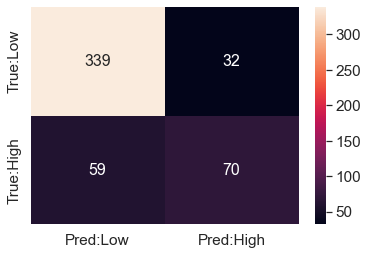

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,7))
plt.ticklabel_format(style='plain',useOffset=False)
sn.set(font_scale=1.4) # for label size
sn.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred,labels=['Low','High']), index=['True:Low',
'True:High'], columns=['Pred:Low', 'Pred:High']), annot=True, fmt='.3g',annot_kws={"size": 16}) # font size

plt.show()

### Try adding job category as one of the features


In [34]:
df.Category.str.contains('IT')

0        True
1        True
2        True
3       False
4       False
        ...  
2495     True
2496    False
2497    False
2498     True
2499     True
Name: Category, Length: 2500, dtype: bool

In [35]:
stop_words2 = stop_words.copy()
stop_words2.add('jobs')
stop_words2.remove("it")

def remove_stopwords(text):
    output= [i for i in text if i not in stop_words2]
    return output

def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    
    tokens = word_tokenizer.tokenize(lowercase)
    
    tokens_no_stopwords = remove_stopwords(tokens)

    text = [wordnet_lemmatizer.lemmatize(word) for word in tokens_no_stopwords]
    
    return text

In [36]:
X_train_2 = train['Category']
X_test_2 = test['Category']

In [37]:
categories = [tokenize_text(cat) for cat in X_train_2]

In [38]:
categories_flatten =[j for sub in categories for j in sub]

In [39]:
word_categories= list(nltk.FreqDist(categories_flatten))

In [40]:
def document_features_category(document,category):
    document_words = set(document)
    document_words2 = set(category)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    for word in word_categories:
        features['category_is({})'.format(word)] = (word in document_words2)
    return features

In [41]:
documents2 =  [(features[i],categories[i],y_train.iloc[i]) for i in range(len(y_train))]

In [42]:
featuresets2 = [(document_features_category(d,cat), c) for (d,cat,c) in documents2]

In [43]:
train_set = featuresets2
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [44]:
classifier.show_most_informative_features(20)

Most Informative Features
        contains(backed) = True             High : Low    =     23.1 : 1.0
            contains(vp) = True             High : Low    =     18.7 : 1.0
          contains(apps) = True             High : Low    =     16.5 : 1.0
         contains(night) = True              Low : High   =     14.9 : 1.0
     contains(alignment) = True             High : Low    =     14.3 : 1.0
       contains(broader) = True             High : Low    =     14.3 : 1.0
    contains(derivative) = True             High : Low    =     14.3 : 1.0
            contains(fx) = True             High : Low    =     14.3 : 1.0
          contains(gaap) = True             High : Low    =     14.3 : 1.0
        contains(huxley) = True             High : Low    =     14.3 : 1.0
             contains(o) = True             High : Low    =     14.3 : 1.0
    contains(partnering) = True             High : Low    =     13.8 : 1.0
    contains(governance) = True             High : Low    =     12.5 : 1.0

In [45]:
# features_test = [tokenize_text(X_test_i) for X_test_i in X_test]
# documents_test = [(features_test[i]) for i in range(len(y_test))]
# featuresets = [(document_features(d)) for d in documents_test]

In [46]:
X_test_2 = test['Category']

In [47]:
categories_test = [tokenize_text(cat) for cat in X_test_2]

In [48]:
documents_test_2 =[(features_test[i],categories_test[i]) for i in range(len(y_test))]

In [49]:
featuresets2  = [(document_features_category(d,cat)) for d,cat in documents_test_2]

In [50]:
y_pred = [classifier.classify(featuresets2[i]) for i in range(len(featuresets2))]

In [51]:
accuracy_score(y_test,y_pred)

0.822

In [52]:
# [classifier.classify(featuresets[i]) for i in len(featuresets)]
confusion_matrix(y_test,y_pred)

array([[ 73,  56],
       [ 33, 338]])

### Try adding location as one of the features

In [53]:
X_train_2 = train['Location']
X_test_2 = test['Location']

In [54]:
locations = [tokenize_text(cat) for cat in X_train_2]

In [55]:
locations_flatten =[j for sub in locations for j in sub]

In [56]:
word_locations= list(nltk.FreqDist(locations_flatten))

In [57]:
def document_features_location(document,location):
    document_words = set(document)
    document_words2 = set(location)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    for word in word_locations:
        features['location_is({})'.format(word)] = (word in document_words2)
    return features

In [58]:
documents2 =  [(features[i],locations[i],y_train.iloc[i]) for i in range(len(y_train))]

In [59]:
featuresets2 = [(document_features_location(d,cat), c) for (d,cat,c) in documents2]

In [60]:
train_set = featuresets2
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [61]:
classifier.show_most_informative_features(20)

Most Informative Features
        contains(backed) = True             High : Low    =     23.1 : 1.0
            contains(vp) = True             High : Low    =     18.7 : 1.0
          contains(apps) = True             High : Low    =     16.5 : 1.0
         contains(night) = True              Low : High   =     14.9 : 1.0
     contains(alignment) = True             High : Low    =     14.3 : 1.0
       contains(broader) = True             High : Low    =     14.3 : 1.0
    contains(derivative) = True             High : Low    =     14.3 : 1.0
            contains(fx) = True             High : Low    =     14.3 : 1.0
          contains(gaap) = True             High : Low    =     14.3 : 1.0
        contains(huxley) = True             High : Low    =     14.3 : 1.0
             contains(o) = True             High : Low    =     14.3 : 1.0
    contains(partnering) = True             High : Low    =     13.8 : 1.0
    contains(governance) = True             High : Low    =     12.5 : 1.0

In [62]:
X_test_2 = test['Location']

In [63]:
locations_test = [tokenize_text(cat) for cat in X_test_2]

In [64]:
documents_test_2 =[(features_test[i],locations_test[i]) for i in range(len(y_test))]

In [65]:
featuresets2  = [(document_features_location(d,cat)) for d,cat in documents_test_2]

In [66]:
y_pred = [classifier.classify(featuresets2[i]) for i in range(len(featuresets2))]

In [67]:
accuracy_score(y_test,y_pred)

0.818

In [68]:
# [classifier.classify(featuresets[i]) for i in len(featuresets)]
confusion_matrix(y_test,y_pred)

array([[ 70,  59],
       [ 32, 339]])